# 1. CV Parsing

In [2]:
!pip install pymupdf spacy
!python -m spacy download en_core_web_trf


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_trf-3.7.3/en_core_web_trf-3.7.3-py3-none-any.whl (457.4 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import os
import re
import fitz  # PyMuPDF
import sqlite3
import spacy



In [4]:
# Load spaCy transformer model
nlp = spacy.load("en_core_web_trf")

/usr/local/lib/python3.10/dist-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filelike, map_location=dev

In [5]:
# ---------- Text Extraction ----------
def extract_text_from_pdf(pdf_path):
    text = ""
    doc = fitz.open(pdf_path)
    for page in doc:
        text += page.get_text()
    return text

# ---------- Contact Info ----------
def extract_email(text):
    match = re.findall(r'\b[\w.-]+?@\w+?\.\w+?\b', text)
    return match[0] if match else None

def extract_phone(text):
    match = re.findall(r'\+?\d[\d\s-]{8,}\d', text)
    return match[0] if match else None

def extract_name(text):
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            return ent.text
    return None

# ---------- Skills and Education ----------
def extract_skills(text, custom_skills=None):
    if not custom_skills:
        custom_skills = ["Python", "Java", "C++", "Machine Learning", "Deep Learning", "Data Analysis", 
                         "NLP", "Flask", "Django", "React", "Node", "SQL", "MongoDB", "AWS", "Git"]
    skills_found = []
    for skill in custom_skills:
        if re.search(r'\b' + re.escape(skill) + r'\b', text, re.IGNORECASE):
            skills_found.append(skill)
    return list(set(skills_found))

def extract_education(text):
    education_keywords = ['Bachelor', 'Master', 'B.Tech', 'B.Sc', 'M.Sc', 'PhD', 'MBA', 'BE', 'Doctorate' ,'Associate Degree', 'Diploma', 'Postgraduate',' Diploma Honors Degree ','Professional Degree']
    edu_found = []
    for line in text.split('\n'):
        if any(keyword in line for keyword in education_keywords):
            edu_found.append(line.strip())
    return edu_found

# ---------- Work Experience Section ----------
def extract_work_experience_section(text):
    match = re.search(r'Work Experience(.*?)(Education|Skills|Certifications|Achievements|Projects|$)', 
                      text, re.IGNORECASE | re.DOTALL)
    return match.group(1).strip() if match else ""

# ---------- Experience Duration Calculation ----------
def extract_experience_years(text):
    work_section = extract_work_experience_section(text)
    year_ranges = re.findall(r'\(?(\d{4})\)?\s*[-–]\s*\(?(\d{4})\)?', work_section)
    
    total_years = 0
    for start, end in year_ranges:
        start, end = int(start), int(end)
        if end >= start:
            total_years += (end - start)
    return total_years

# ---------- Achievements ----------
def extract_achievements(text):
    achievements = []
    for line in text.split('\n'):
        if re.search(r'(award|achievement|honor|published|paper|recognition|rank|topper|certificate|winner)', line, re.IGNORECASE):
            achievements.append(line.strip())
    return achievements

def extract_certifications(text):
    lines = text.split("\n")
    cert_keywords = ["certified", "certification", "certificate"]
    return [line.strip() for line in lines if any(k in line.lower() for k in cert_keywords)]

def extract_entities(text):
    doc = nlp(text)
    entities = {"PERSON": [], "ORG": [], "SKILLS": []}
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            entities["PERSON"].append(ent.text)
        elif ent.label_ == "ORG":
            entities["ORG"].append(ent.text)

    skills_list = ["Java", "SQL", "Python", "Spring Boot", "MySQL", "Kafka", "AWS", "Azure", "Azure DevOps", "Docker"]
    entities["SKILLS"] = [skill for skill in skills_list if skill.lower() in text.lower()]
    return entities

In [6]:
def parse_cv(file_path):
    text = extract_text_from_pdf(file_path)
    email = extract_email(text)
    phone = extract_phone(text)
    entities = extract_entities(text)
    education = extract_education(text)
    work_ex = extract_experience_years(text)
    certifications = extract_certifications(text)
    achievements = extract_achievements(text)

    parsed = {
        "Name": entities["PERSON"][0] if entities["PERSON"] else None,
        "Email": email,
        "Phone": phone,
        "Education": education,
        "Work Experience": work_ex,
        "Skills": entities["SKILLS"],
        "Certifications": certifications,
        "Achievements": achievements,
        "Tech Stack": entities["SKILLS"]
    }
    return parsed

In [7]:
cv_path = "/kaggle/input/jobscreening/Dataset-Acc/CVs/C1061.pdf"  # Replace with your file
parsed_data = parse_cv(cv_path)
print(parsed_data)


/usr/local/lib/python3.10/dist-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


{'Name': 'Alyssa Chavez', 'Email': 'alyssachavez88@gmail.com', 'Phone': '+1-465-3587', 'Education': ['Diploma in Software Engineering (2013-2015)'], 'Work Experience': 4, 'Skills': ['Java', 'SQL', 'Spring Boot', 'MySQL', 'Kafka', 'AWS', 'Azure', 'Azure DevOps'], 'Certifications': ['Certifications', 'AWS Certified Solutions Architect - Validated expertise in designing and deploying scalable AWS'], 'Achievements': ['Achievements', 'Published a research paper on AI ethics - Contributed to an AI ethics framework adopted by industry'], 'Tech Stack': ['Java', 'SQL', 'Spring Boot', 'MySQL', 'Kafka', 'AWS', 'Azure', 'Azure DevOps']}


# 2. Storing Parsed Resume Data into SQLite

In [8]:
# ========== SQLITE STORAGE ==========
def create_db():
    conn = sqlite3.connect("resumes.db")
    cursor = conn.cursor()
    cursor.execute('DROP TABLE IF EXISTS parsed_resumes')
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS parsed_resumes (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT,
            email TEXT,
            phone TEXT,
            education TEXT,
            work_experience TEXT,
            skills TEXT,
            certifications TEXT,
            achievements TEXT,
            tech_stack TEXT,
            filename TEXT
        )
    ''')
    conn.commit()
    conn.close()


def store_parsed_data(data, filename):
    conn = sqlite3.connect("resumes.db")
    cursor = conn.cursor()
    cursor.execute('''
        INSERT INTO parsed_resumes (
            name, email, phone, education, work_experience,
            skills, certifications, achievements, tech_stack, filename
        )
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        data.get("Name", ""),
        data.get("Email", ""),
        data.get("Phone", ""),
        "\n".join(data.get("Education", [])) if isinstance(data.get("Education"), list) else "",
        str(data.get("Work Experience", "")),  # It's a number, just convert to str
        ", ".join(data.get("Skills", [])) if isinstance(data.get("Skills"), list) else "",
        "\n".join(data.get("Certifications", [])) if isinstance(data.get("Certifications"), list) else "",
        "\n".join(data.get("Achievements", [])) if isinstance(data.get("Achievements"), list) else "",
        ", ".join(data.get("Tech Stack", [])) if isinstance(data.get("Tech Stack"), list) else "",
        filename
    ))
    conn.commit()
    conn.close()



In [9]:
# ========== PROCESS MULTIPLE RESUMES ==========
def process_all_resumes(folder_path):
    create_db()
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            file_path = os.path.join(folder_path, filename)
            print(f"\n📄 Processing: {filename}")
            try:
                parsed_data = parse_cv(file_path)
                store_parsed_data(parsed_data, filename)
                print("✅ Stored successfully.")
            except Exception as e:
                print(f"❌ Error in {filename}: {e}")

# ========== RUN HERE ==========
cv_folder_path = "/kaggle/input/jobscreening/Dataset-Acc/CVs/"
process_all_resumes(cv_folder_path)


📄 Processing: C8692.pdf
✅ Stored successfully.

📄 Processing: C3019.pdf
✅ Stored successfully.

📄 Processing: C3899.pdf
✅ Stored successfully.

📄 Processing: C7996.pdf
✅ Stored successfully.

📄 Processing: C9567.pdf
✅ Stored successfully.

📄 Processing: C3464.pdf
✅ Stored successfully.

📄 Processing: C8203.pdf
✅ Stored successfully.

📄 Processing: C3620.pdf
✅ Stored successfully.

📄 Processing: C8239.pdf
✅ Stored successfully.

📄 Processing: C3627.pdf
✅ Stored successfully.

📄 Processing: C5725.pdf
✅ Stored successfully.

📄 Processing: C5390.pdf
✅ Stored successfully.

📄 Processing: C7318.pdf
✅ Stored successfully.

📄 Processing: C2250.pdf
✅ Stored successfully.

📄 Processing: C7497.pdf
✅ Stored successfully.

📄 Processing: C6746.pdf
✅ Stored successfully.

📄 Processing: C2775.pdf
✅ Stored successfully.

📄 Processing: C2669.pdf
✅ Stored successfully.

📄 Processing: C5121.pdf
✅ Stored successfully.

📄 Processing: C1070.pdf
✅ Stored successfully.

📄 Processing: C9779.pdf
✅ Stored succes

In [10]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("resumes.db")

# Read the table into a DataFrame
cv_df = pd.read_sql_query("SELECT * FROM parsed_resumes LIMIT 10", conn)

# Show the table
pd.set_option('display.max_colwidth', None)  # To see full text in columns
display(cv_df)

# Close the connection
conn.close()


,id,name,email,phone,education,work_experience,skills,certifications,achievements,tech_stack,filename
0,1,Corey Murphy,coreymurphy92@gmail.com,+1-651-4982,Bachelor of Engineering in Information Technology (2014-2018),4,"AWS, Azure",Certifications\nAWS Certified Solutions Architect - Validated expertise in designing and deploying scalable AWS,Achievements,"AWS, Azure",C8692.pdf
1,2,Jeremy Copeland,jeremycopeland98@gmail.com,+1-325-8301,,8,AWS,Certifications\nAWS Certified Solutions Architect - Validated expertise in designing and deploying scalable AWS,Achievements,AWS,C3019.pdf
2,3,Oscar Perry,oscarperry25@gmail.com,+1-901-6901,Bachelor of Engineering in Information Technology (2014-2018)\nBachelor of Science in Computer Science (2015-2019),4,"Java, SQL, Spring Boot, MySQL, Kafka, Azure, Azure DevOps","Certifications\nCertified Ethical Hacker (CEH) - Demonstrated proficiency in ethical hacking, network security, and",Achievements,"Java, SQL, Spring Boot, MySQL, Kafka, Azure, Azure DevOps",C3899.pdf
3,4,Jane Shepard,janeshepard88@gmail.com,+1-412-5549,,4,"SQL, Python, Docker","Certifications\nCertified Ethical Hacker (CEH) - Demonstrated proficiency in ethical hacking, network security, and",Achievements,"SQL, Python, Docker",C7996.pdf
4,5,Julie Duffy,julieduffy97@gmail.com,+1-374-9179,Master of Science in Data Science (2019-2021)\nBachelor of Engineering in Information Technology (2014-2018),4,Python,"Certifications\nCertified Ethical Hacker (CEH) - Demonstrated proficiency in ethical hacking, network security, and",Achievements\nPublished a research paper on AI ethics - Contributed to an AI ethics framework adopted by industry,Python,C9567.pdf
5,6,William Mathis,williammathis33@gmail.com,+1-493-9264,Diploma in Software Engineering (2013-2015)\nMaster of Science in Data Science (2019-2021),8,"AWS, Azure",Certifications\nAWS Certified Solutions Architect - Validated expertise in designing and deploying scalable AWS,Achievements,"AWS, Azure",C3464.pdf
6,7,Kyle Munoz,kylemunoz16@gmail.com,+1-832-4616,Diploma in Software Engineering (2013-2015),4,AWS,Certifications\nAWS Certified Solutions Architect - Validated expertise in designing and deploying scalable AWS,Achievements,AWS,C8203.pdf
7,8,Holly Kennedy,hollykennedy38@gmail.com,+1-586-7244,Bachelor of Engineering in Information Technology (2014-2018)\nMaster of Business Administration (2017-2019)\nBachelor of Science in Computer Science (2015-2019),8,"SQL, Python, AWS, Azure, Docker",Certifications\nAWS Certified Solutions Architect - Validated expertise in designing and deploying scalable AWS,Achievements,"SQL, Python, AWS, Azure, Docker",C3620.pdf
8,9,Malik Roberts,malikroberts90@gmail.com,+1-346-8045,Bachelor of Engineering in Information Technology (2014-2018)\nMaster of Business Administration (2017-2019)\nDiploma in Software Engineering (2013-2015),8,"SQL, Python, AWS, Docker",Certifications\nAWS Certified Solutions Architect - Validated expertise in designing and deploying scalable AWS,Achievements,"SQL, Python, AWS, Docker",C8239.pdf
9,10,Matthew Rubio,matthewrubio56@gmail.com,+1-545-1297,Master of Science in Data Science (2019-2021)\nBachelor of Science in Computer Science (2015-2019),8,"SQL, Python, AWS, Azure, Docker",Certifications\nAWS Certified Solutions Architect - Validated expertise in designing and deploying scalable AWS,Achievements\nPublished a research paper on AI ethics - Contributed to an AI ethics framework adopted by industry,"SQL, Python, AWS, Azure, Docker",C3627.pdf


In [11]:
import sqlite3
import pandas as pd

# Connect to the DB
conn = sqlite3.connect("resumes.db")

# Load data into a DataFrame
cv_df = pd.read_sql_query("SELECT * FROM parsed_resumes", conn)

# Save it as a CSV file
cv_df.to_csv("parsed_resumes.csv", index=False)

# Close the connection
conn.close()

print("✅ Resume data successfully saved to 'parsed_resumes.csv'")


✅ Resume data successfully saved to 'parsed_resumes.csv'


# 3. Job Description Summary

In [12]:
!pip install transformers --quiet


In [13]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Load model and tokenizer
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def get_answer(jd_text, question):
    prompt = f"""Extract the answer from the job description below.

Job Description:
{jd_text}

Question: {question}"""

    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(**inputs, max_length=50)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer.strip()

def get_structured_summary(jd_text):
    return {
        "Required Skills": get_answer(jd_text, "Extract a bulleted list of technical and soft skills explicitly required in the job description below Include only skills directly mentioned like programming languages, tools, frameworks, competencies"),
        "Qualifications": get_answer(jd_text, "What qualifications are mentioned in this job description?"),
        "Experience": get_answer(jd_text, "How much experience is required for this job?")
    }


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [14]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from tqdm import tqdm# Load your JD CSV file
# df = pd.read_csv("/kaggle/input/jobscreening/Dataset-Acc/job_description.csv")
df = pd.read_csv("/kaggle/input/jobscreening/Dataset-Acc/job_description.csv", encoding='ISO-8859-1')

df.columns = df.columns.str.strip()  # Remove extra whitespace
print("✅ Columns:", df.columns)  # DEBUG

# Add summaries
tqdm.pandas()
df['jd_summary'] = df['Job Description'].progress_apply(get_structured_summary)

# Save output
df.to_csv("summarized_jds.csv", index=False)
print("✅ Job description summaries saved to jd_with_summaries.csv")

✅ Columns: Index(['Job Title', 'Job Description', 'Unnamed: 2'], dtype='object')


100%|██████████| 20/20 [05:54<00:00, 17.75s/it]

✅ Job description summaries saved to jd_with_summaries.csv


In [15]:
jd_df = pd.read_csv("summarized_jds.csv")


In [16]:
conn = sqlite3.connect("resumes.db")
jd_df.to_sql("jd_summaries", conn, if_exists="replace", index=False)
conn.close()


In [17]:
import sqlite3

conn = sqlite3.connect("resumes.db")
cursor = conn.cursor()

# List all tables in the DB
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("📦 Tables in DB:", tables)

conn.close()


📦 Tables in DB: [('sqlite_sequence',), ('parsed_resumes',), ('jd_summaries',)]


# 4. Resume - JD Matching

In [18]:
import re

def prepare_jd_text(row):
    summary = row.get('jd_summary', '')

    # Extract skills from a predefined skill list
    def extract_skills(text):
        skill_keywords = ['Python', 'Java', 'C++', 'JavaScript', 'React', 'Angular', 'SQL', 'AWS', 'Django', 'Flask', 'Docker', 'Kubernetes']
        found = [skill for skill in skill_keywords if skill.lower() in text.lower()]
        return ', '.join(found) if found else "Not specified"

    # Extract qualifications using a regex pattern
    def extract_qualifications(text):
        pattern = r"(Bachelor(?:'s)?|Master(?:'s)?|B\.Tech|M\.Tech|BSc|MSc|PhD)[^.,;\n]*"
        matches = re.findall(pattern, text, re.IGNORECASE)
        return ', '.join(set(matches)) if matches else "Not specified"

    # Extract years of experience using a regex pattern
    def extract_experience_requirements(text):
        match = re.search(r'(\d+)\+?\s*(?:years|yrs)', text)
        return f"{match.group(1)} years" if match else "Not specified"

    # Apply the parsers
    skills = extract_skills(summary)
    qualifications = extract_qualifications(summary)
    experience = extract_experience_requirements(summary)

    # Join all parts into structured JD text
    return (
        f"Required Skills: {skills}\n"
        f"Qualifications: {qualifications}\n"
        f"Experience Requirements: {experience}"
    )


In [19]:
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer, util
from datetime import datetime

# Load the embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
print("✅ CV DataFrame Columns:", cv_df.columns.tolist())


✅ CV DataFrame Columns: ['id', 'name', 'email', 'phone', 'education', 'work_experience', 'skills', 'certifications', 'achievements', 'tech_stack', 'filename']


In [21]:
# ---------- STEP 1: Extract experience years from date ranges ----------
def extract_experience_years(experience_list):
    total_years = 0
    for entry in experience_list:
        matches = re.findall(r'(\d{4})\s*[-–]\s*(Present|\d{4})', entry)
        for start, end in matches:
            start_year = int(start)
            end_year = datetime.now().year if end.lower() == 'present' else int(end)
            if end_year >= start_year:
                total_years += end_year - start_year
    return total_years

# ---------- STEP 2: Prepare text for embeddings ----------
# def prepare_jd_text(row):
#     return f"{row['jd_summary']}"

def prepare_cv_text(row):
    skills_text = row['skills']
    education_text = ' '.join(row['education']) if isinstance(row['education'], list) else row['education']
    experience_text = ' '.join(row['work_experience']) if isinstance(row['work_experience'], list) else row['work_experience']
    
    return f"{skills_text} {education_text} {experience_text}"

# Prepare texts
jd_texts = jd_df.apply(prepare_jd_text, axis=1).tolist()
cv_texts = cv_df.apply(prepare_cv_text, axis=1).tolist()

# ---------- STEP 3: Generate sentence embeddings ----------
jd_embeddings = model.encode(jd_texts, convert_to_tensor=True)
cv_embeddings = model.encode(cv_texts, convert_to_tensor=True)

# ---------- STEP 4: Compute cosine similarity ----------
similarity_matrix = util.cos_sim(jd_embeddings, cv_embeddings)

# ---------- STEP 5: Build final result DataFrame ----------
results = []
threshold = 0.5  # Set random threshold for shortlisting

for job_idx, job_row in enumerate(similarity_matrix):
    job_title = jd_df.iloc[job_idx]['Job Title']
    for cv_idx, score in enumerate(job_row):
        name = cv_df.iloc[cv_idx]['name']
        jd_role = job_title
        sim_score = float(score)
        shortlisted = "Yes" if sim_score >= threshold else "No"
        
        # Calculate experience in years
        experience_list = cv_df.iloc[cv_idx]['work_experience']
        total_exp = extract_experience_years(experience_list) if isinstance(experience_list, list) else 0
        
        # Get any other details if needed
        contact = cv_df.iloc[cv_idx].get('phone', 'N/A')
        email = cv_df.iloc[cv_idx].get('email', 'N/A')

        results.append({
            'Name': name,
            'Contact': contact,
            'Email': email,
            'Job Role': jd_role,
            'Score': round(sim_score, 3),
            'Shortlisted': shortlisted
        })

# Convert results to DataFrame
matches_df = pd.DataFrame(results)

# ---------- STEP 6: Display or export ----------
# Optionally export to CSV
matches_df.to_csv('matching_results.csv', index=False)
matches_df.head()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

,Name,Contact,Email,Job Role,Score,Shortlisted
0,Corey Murphy,+1-651-4982,coreymurphy92@gmail.com,Software Engineer,0.303,No
1,Jeremy Copeland,+1-325-8301,jeremycopeland98@gmail.com,Software Engineer,0.078,No
2,Oscar Perry,+1-901-6901,oscarperry25@gmail.com,Software Engineer,0.410,No
3,Jane Shepard,+1-412-5549,janeshepard88@gmail.com,Software Engineer,0.202,No
4,Julie Duffy,+1-374-9179,julieduffy97@gmail.com,Software Engineer,0.518,Yes


In [22]:
matches_df[matches_df["Score"]>0.70]

,Name,Contact,Email,Job Role,Score,Shortlisted
214,Robert Lewis,+1-529-1254,robertlewis17@gmail.com,Data Scientist,0.705,Yes
254,Robert Smith,+1-569-9945,robertsmith89@gmail.com,Data Scientist,0.732,Yes
324,Stephen Hayden,+1-774-4762,stephenhayden76@gmail.com,Data Scientist,0.704,Yes
325,David Hull,+1-422-5310,davidhull82@gmail.com,Data Scientist,0.704,Yes
341,Pamela Kerr,+1-453-5337,pamelakerr20@gmail.com,Data Scientist,0.704,Yes
351,Harry Jones,+1-939-5530,harryjones50@gmail.com,Data Scientist,0.705,Yes
383,Thomas Baird,+1-605-1775,thomasbaird44@gmail.com,Data Scientist,0.704,Yes
389,Robert Flores,+1-985-1665,robertflores62@gmail.com,Data Scientist,0.716,Yes
635,Brad Walker,+1-704-3766,bradwalker69@gmail.com,Cloud Engineer,0.714,Yes
1035,Brad Walker,+1-704-3766,bradwalker69@gmail.com,Machine Learning Engineer,0.714,Yes


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


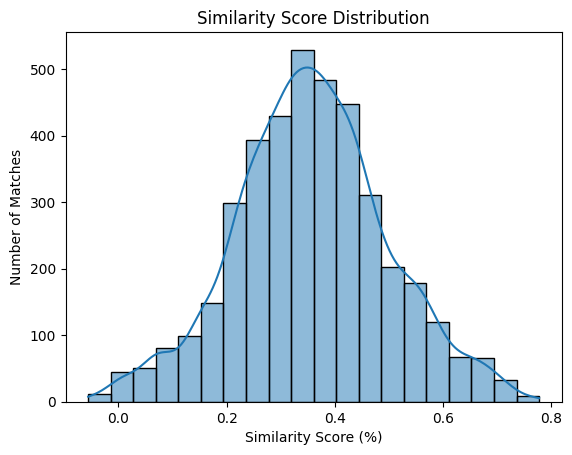

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(matches_df['Score'], bins=20, kde=True)
plt.title("Similarity Score Distribution")
plt.xlabel("Similarity Score (%)")
plt.ylabel("Number of Matches")
plt.show()


In [24]:
top_matches_per_jd = matches_df.sort_values(by='Score', ascending=False).groupby('Job Role').head(3)


# 5. SQLite Storing

In [25]:
import sqlite3

# Connect to the existing database (or create if not exists)
conn = sqlite3.connect("resumes.db")
cursor = conn.cursor()

# Create a new table for match scores
cursor.execute('''
CREATE TABLE IF NOT EXISTS shortlisted_candidates (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT,
    contact TEXT,
    email TEXT,
    job_role TEXT,
    similarity_score REAL,
    shortlisted TEXT,
    UNIQUE(email, job_role)
)
''')

conn.commit()
conn.close()


In [26]:
def store_shortlisted_to_sqlite(matches_df):
    conn = sqlite3.connect("resumes.db")
    cursor = conn.cursor()

    for _, row in matches_df.iterrows():
        cursor.execute('''
            INSERT OR IGNORE INTO shortlisted_candidates (
            name, contact, email, job_role, similarity_score, shortlisted
            ) VALUES (?, ?, ?, ?, ?, ?)
        ''', (
            row['Name'],
            row['Contact'],
            row['Email'],
            row['Job Role'],
            float(row['Score']),
            row['Shortlisted']
        ))

    conn.commit()
    conn.close()
    print("✅ All shortlisted candiadtes stored in 'resume_jd_matches' table.")

# Call the function
store_shortlisted_to_sqlite(matches_df)

✅ All shortlisted candiadtes stored in 'resume_jd_matches' table.


In [29]:
def view_top_matches(threshold=0.70):
    conn = sqlite3.connect("resumes.db")
    df = pd.read_sql_query(f'''
        SELECT * FROM shortlisted_candidates WHERE similarity_score >= {threshold}
        ORDER BY similarity_score DESC
        
    ''', conn)
    conn.close()
    return df

# Example: view top matches over 80%
view_top_matches(0.70)


,id,name,contact,email,job_role,similarity_score,shortlisted
0,1762,Mark Griffin,+1-627-1709,markgriffin54@gmail.com,Big Data Engineer,0.778,Yes
1,1609,Malik Roberts,+1-346-8045,malikroberts90@gmail.com,Big Data Engineer,0.777,Yes
2,1622,Sarah Mccullough,+1-776-4613,sarahmccullough41@gmail.com,Big Data Engineer,0.769,Yes
3,1720,Amanda Miller,+1-739-6090,amandamiller19@gmail.com,Big Data Engineer,0.769,Yes
4,1616,Krystal Quinn,+1-487-2261,krystalquinn71@gmail.com,Big Data Engineer,0.766,Yes
5,1678,Philip Perez,+1-505-6840,philipperez65@gmail.com,Big Data Engineer,0.762,Yes
6,1761,Ryan Smith,+1-410-6094,ryansmith96@gmail.com,Big Data Engineer,0.752,Yes
7,1757,Kimberly Green,+1-750-6806,kimberlygreen64@gmail.com,Big Data Engineer,0.743,Yes
8,1642,Christine Hines,+1-474-4527,christinehines27@gmail.com,Big Data Engineer,0.738,Yes
9,255,Robert Smith,+1-569-9945,robertsmith89@gmail.com,Data Scientist,0.732,Yes


# 6. Emailing shortlisted candidates

In [30]:
pip install yagmail


Note: you may need to restart the kernel to use updated packages.


In [31]:
import yagmail

# One-time setup to store your Gmail credentials securely
# Run this only ONCE, not every time
# Replace YOUR_EMAIL with your Gmail (e.g., "abc@gmail.com")
# It will prompt you for the password once and store it securely
# yagmail.register("YOUR_EMAIL", "YOUR_APP_PASSWORD")


In [32]:
def send_emails_to_shortlisted(threshold=0.75):
    import yagmail

    import yagmail

    # Replace with your credentials or use environment variables for security
    sender_email = "varshithamasaram@gmail.com"
    sender_password = "fliz bvno vajb xehh"  # Not your Gmail password – use App Password if 2FA is on

    yag = yagmail.SMTP(user=sender_email, password=sender_password)


    # Fetch shortlisted candidates from the DB
    conn = sqlite3.connect("resumes.db")
    query = f'''
    SELECT r.email, r.name, r.job_role, r.similarity_score 
    FROM shortlisted_candidates r
    WHERE r.similarity_score >= 0.75
    ORDER BY r.similarity_score DESC
'''

    shortlisted = pd.read_sql_query(query, conn)
    conn.close()

    print(f"📤 Sending emails to {len(shortlisted)} shortlisted candidates...")

    for _, row in shortlisted.iterrows():
        subject = f"Interview Invitation for {row['job_role']}"
        body = f"""
Hi {row['name']},

Congratulations! 🎉

You have been shortlisted for the role of *{row['job_role']}* based on your resume evaluation.

Your match score: {round(row['similarity_score'], 2)}%

We’d like to invite you to the next round of interviews. Please respond to this email to confirm your availability.

Best Regards,  
Hiring Team
        """

        # You can attach resume if needed
        # attachments = [f"/kaggle/input/resume_folder/{row['filename']}"]
        yag.send(to=row['email'], subject=subject, contents=body)
        print(f"✅ Email sent to: {row['email']}")

    print("📬 All emails sent successfully.")


In [33]:
send_emails_to_shortlisted(threshold=0.75)


📤 Sending emails to 7 shortlisted candidates...
✅ Email sent to: markgriffin54@gmail.com
✅ Email sent to: malikroberts90@gmail.com
✅ Email sent to: sarahmccullough41@gmail.com
✅ Email sent to: amandamiller19@gmail.com
✅ Email sent to: krystalquinn71@gmail.com
✅ Email sent to: philipperez65@gmail.com
✅ Email sent to: ryansmith96@gmail.com
📬 All emails sent successfully.


# 7. Stream-lit Dashboard

In [34]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 67.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 78.9 MB/s eta 0:00:00:00:0100:01


In [38]:
import sqlite3

# Connect to the database
conn = sqlite3.connect("resumes.db")
cursor = conn.cursor()

# Query all table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch and print
tables = cursor.fetchall()
print("📋 Tables in the database:")
for table in tables:
    print("👉", table[0])

conn.close()


📋 Tables in the database:
👉 sqlite_sequence
👉 parsed_resumes
👉 jd_summaries
👉 shortlisted_candidates


In [39]:
streamlit_code = """

import streamlit as st
import pandas as pd
import sqlite3
import plotly.express as px

st.set_page_config(page_title="Resume Screening Dashboard", layout="wide")

# Connect to the database
conn = sqlite3.connect("resumes.db")
cursor = conn.cursor()

# Load resumes table
resumes_df = pd.read_sql_query("SELECT * FROM parsed_resumes", conn)

# Load JD summaries
jd_df = pd.read_sql_query("SELECT * FROM jd_summaries", conn)

# Load matches
matches_df = pd.read_sql_query("SELECT * FROM shortlisted_candidates", conn)

st.title("📊 Resume Screening Dashboard")

tab1, tab2, tab3, tab4 = st.tabs(["📁 Parsed Resumes", "📄 JD Summaries", "🔍 Resume-JD Matching", "📬 Shortlisted Emails"])

with tab1:
    st.subheader("Parsed Resumes Data")
    st.dataframe(resumes_df)

with tab2:
    st.subheader("Job Descriptions & Summaries")
    st.dataframe(jd_df)

with tab3:
    st.subheader("Resume-JD Matching Scores")
    st.dataframe(matches_df)

    st.markdown("### 📈 Similarity Score Distribution")
    fig = px.histogram(matches_df, x="similarity_score", nbins=20, title="Distribution of Matching Scores")
    st.plotly_chart(fig)

with tab4:
    st.subheader("Shortlisted Candidates (score ≥ 75%)")
    threshold = 0.75
    query = f'''
        SELECT r.name, r.email, m.filename, r.similarity_score, r.job_role
        FROM shortlisted_candidates r
        JOIN parsed_resumes m ON m.name = r.name
        WHERE r.similarity_score >= {threshold}
        ORDER BY r.similarity_score DESC
    '''
    shortlisted = pd.read_sql_query(query, conn)
    st.dataframe(shortlisted)

"""
# Save it to a .py file
with open("dashboard.py", "w") as f:
    f.write(streamlit_code)


In [40]:
# new_streamlit_code = """

# import streamlit as st
# import pandas as pd
# import sqlite3
# import plotly.express as px
# import fitz  # PyMuPDF
# import spacy
# from sentence_transformers import SentenceTransformer, util
# from transformers import pipeline
# import yagmail
# import tempfile
# import os

# # Load models once
# nlp = spacy.load("en_core_web_trf")
# summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
# embed_model = SentenceTransformer("all-MiniLM-L6-v2")

# def send_email(to, subject, content):
#     try:
#         yag = yagmail.SMTP("varshithamasaram@gmail.com", "fliz bvno vajb xehh")
#         yag.send(to=to, subject=subject, contents=content)
#         return True
#     except Exception as e:
#         return False

# def extract_text_from_pdf(uploaded_file):
#     text = ""
#     with fitz.open(stream=uploaded_file.read(), filetype="pdf") as doc:
#         for page in doc:
#             text += page.get_text()
#     return text

# def get_candidate_details(parsed_text):
#     doc = nlp(parsed_text)
#     email = ""
#     name = "Candidate"
#     for ent in doc.ents:
#         if ent.label_ == "EMAIL":
#             email = ent.text
#         if ent.label_ == "PERSON" and len(ent.text.split()) >= 2:
#             name = ent.text
#             break
#     return name, email

# # Load summarized JD dataset from DB if exists
# conn = sqlite3.connect("job_screening.db")

# st.set_page_config(page_title="Job Screening Dashboard", layout="wide")
# st.title("📊 AI-Powered Job Screening Dashboard")

# tabs = st.tabs(["📁 Dataset Results", "🧪 Real-Time Screening"])

# # Tab 1: Results from dataset
# with tabs[0]:
#     st.subheader("📁 Dataset-Based Screening Results")

#     try:
#         resumes_df = pd.read_sql_query("SELECT * FROM parsed_resumes", conn)
#         matches_df = pd.read_sql_query("SELECT * FROM resume_jd_matches", conn)
#         jd_df = pd.read_sql_query("SELECT * FROM jd_summaries", conn)

#         st.write("### Resume-JD Match Scores")
#         st.dataframe(matches_df)

#         st.write("### JD Summary Visuals")
#         fig = px.bar(jd_df, x='job_title', y='summary')
#         st.plotly_chart(fig)
#     except Exception as e:
#         st.warning(f""🔁 Please run data preprocessing and matching first.

# Error details: {e}")


# # Tab 2: Real-time screening
# with tabs[1]:
#     st.subheader("🧪 Real-Time Job Screening")

#     jd_text = st.text_area("📄 Paste Job Description Text")
#     resume_files = st.file_uploader("📤 Upload Resumes (PDFs)", type=["pdf"], accept_multiple_files=True)
#     threshold = st.slider("🎯 Match Score Threshold (%)", 0, 100, 60)

#     if jd_text and resume_files:
#         st.info("⏳ Processing...")

#         jd_summary = summarizer(jd_text[:1024], max_length=100, min_length=30, do_sample=False)[0]['summary_text']
#         jd_embed = embed_model.encode(jd_summary, convert_to_tensor=True)

#         results = []
#         for resume_file in resume_files:
#             text = extract_text_from_pdf(resume_file)
#             name, email = get_candidate_details(text)
#             resume_embed = embed_model.encode(text, convert_to_tensor=True)
#             score = util.cos_sim(jd_embed, resume_embed).item() * 100
#             results.append({
#                 "Name": name,
#                 "Email": email,
#                 "Match Score": round(score, 2)
#             })

#         results_df = pd.DataFrame(results)
#         shortlisted = results_df[results_df['Match Score'] >= threshold]

#         st.success(f"🎉 {len(shortlisted)} candidates shortlisted!")
#         st.dataframe(shortlisted)

#         if not shortlisted.empty:
#             if st.button("📨 Send Emails to Shortlisted Candidates"):
#                 all_sent = True
#                 for _, row in shortlisted.iterrows():
#                     status = send_email(
#                         to=row['Email'],
#                         subject="Job Opportunity Match!",
#                         content=f"Hi {row['Name']},\n\nYou have been shortlisted based on your resume for the job opportunity provided.\nMatch Score: {row['Match Score']}%.\n\nRegards,\nRecruitment Team"
#                     )
#                     if status:
#                         st.success(f"Email sent to {row['Email']}")
#                     else:
#                         all_sent = False
#                         st.error(f"Failed to send to {row['Email']}")
#                 if all_sent:
#                     st.balloons()

# conn.close()

# """
# # Save it to a .py file
# with open("new_dashboard.py", "w") as f:
#     f.write(new_streamlit_code)


# 8. Test New Resume Against JD

In [41]:
# import streamlit as st
# import fitz  # PyMuPDF
# import spacy
# from sentence_transformers import SentenceTransformer, util
# from transformers import pipeline

# # Load your models once
# nlp = spacy.load("en_core_web_trf")
# summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
# embed_model = SentenceTransformer("all-MiniLM-L6-v2")

# st.header("📄 Test New Resume with Job Description")

# resume_file = st.file_uploader("Upload a Resume (PDF)", type=["pdf"])
# job_description = st.text_area("Paste Job Description Text Here")

# if resume_file and job_description:
#     st.info("⏳ Processing...")

#     # Read and parse the resume
#     with fitz.open(stream=resume_file.read(), filetype="pdf") as doc:
#         text = ""
#         for page in doc:
#             text += page.get_text()

#     parsed = nlp(text)
#     resume_text = text  # You can apply smarter parsing if needed

#     # Summarize the JD
#     jd_summary = summarizer(job_description, max_length=100, min_length=30, do_sample=False)[0]['summary_text']

#     # Get embeddings
#     jd_embed = embed_model.encode(jd_summary, convert_to_tensor=True)
#     resume_embed = embed_model.encode(resume_text, convert_to_tensor=True)

#     # Cosine similarity
#     score = util.cos_sim(jd_embed, resume_embed).item() * 100

#     st.success(f"✅ Match Score: **{score:.2f}%**")

#     if score >= 75:
#         st.balloons()
#         st.markdown("🎯 This resume is a **strong match**!")
#     elif score >= 50:
#         st.markdown("👍 This resume is a **moderate match**.")
#     else:
#         st.warning("⚠️ This resume has **low relevance** to the JD.")
